# Second UNet arhitecture Results

Import the required libraries

In [1]:
import os
import sys

sys.path.append("/home/mn628/FEDERATED_LEARNING/mn628")

In [2]:
import matplotlib.pyplot as plt
import netron
import numpy as np
import seaborn as sns
import torch
from torchviz import make_dot

from configs.unet_paper_config import train_save
from src.plot_notebooks import unet_paper_aug_comparison
from src.UNet_paper.prepare_data import *
from src.UNet_paper.train_and_eval import (create_lr_scheduler, evaluate,
                                           train_one_epoch)
from src.UNet_paper.unet import UNet

### Model arhitecture info and visualisation

One image, could've been just a random dummy input

In [3]:
train_images = np.load(train_save)
train_images = np.transpose(train_images, (0, 3, 1, 2))[:1]
train_images.shape

(1, 1, 128, 128)

In [4]:
dummy_input = torch.from_numpy(train_images).float()

Model

In [5]:
model = UNet(in_channels=1, num_classes=1, bilinear=True)
output = model(dummy_input)

Visualisation 1

In [22]:
dot = make_dot(output["out"], params=dict(model.named_parameters()))
dot.render(
    "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_paper/unet_architecture",
    format="png",
)

'/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_paper/unet_architecture.png'

Visualisation 2 (open with Netron)

In [ ]:
onnx_path = "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_paper/unet_model.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
    verbose=True,
)

Model info

In [9]:
print(model)

UNet(
  (in_conv): DoubleConv(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Down(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dow

### Augmentation comparison - validation learning curves

In [3]:
unet_loss, unet_dice = [], []
with open(
    "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_paper/results/results.txt", "r"
) as file:
    lines = file.readlines()
    for line in lines:
        if "dice coefficient" in line:
            unet_dice.append(float(line.split(":")[-1].strip()))
        if "loss" in line:
            unet_loss.append(float(line.split(":")[-1].strip()))

unet_augmented_loss, unet_augmented_dice = [], []
with open(
    "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_paper/results/results_augmented.txt",
    "r",
) as file:
    lines = file.readlines()
    for line in lines:
        if "dice coefficient" in line:
            unet_augmented_dice.append(float(line.split(":")[-1].strip()))
        if "loss" in line:
            unet_augmented_loss.append(float(line.split(":")[-1].strip()))

In [4]:
print(max(unet_dice), max(unet_augmented_dice), unet_dice[-1], unet_augmented_dice[-1])

0.46 0.501 0.352 0.445


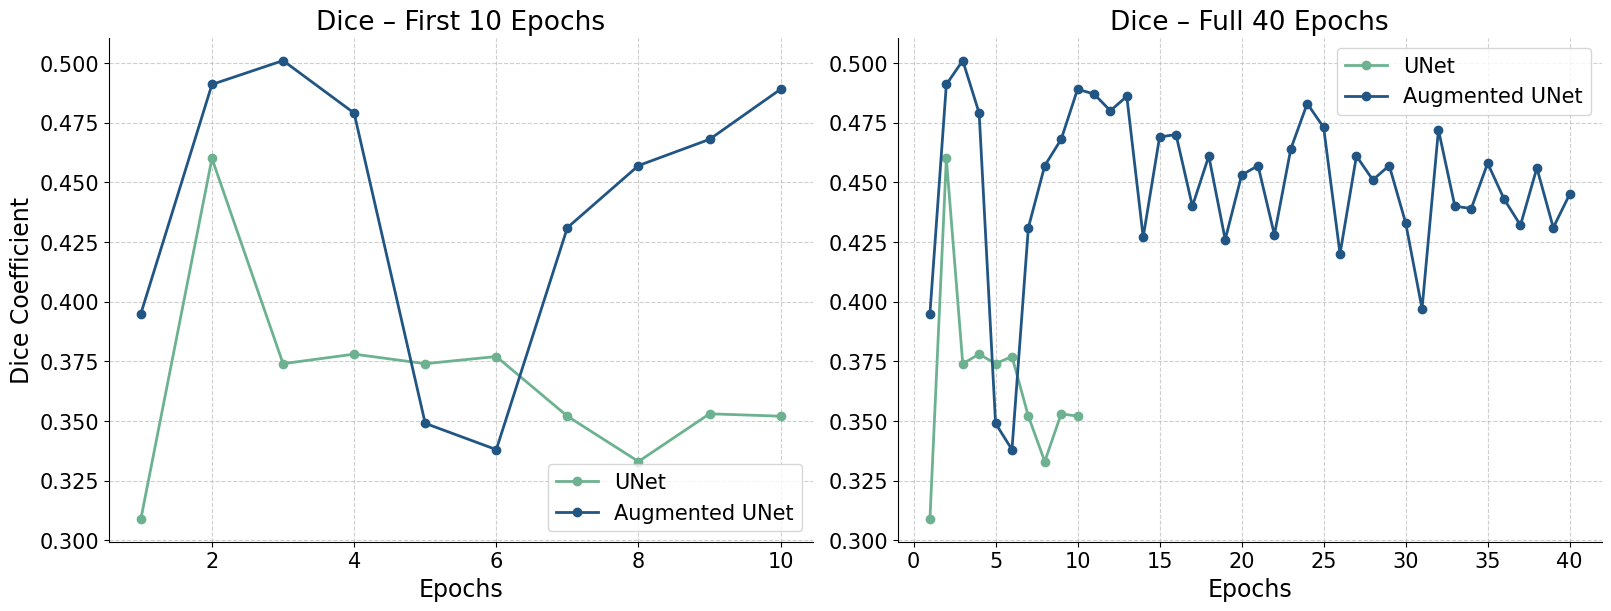

In [5]:
unet_paper_aug_comparison(unet_dice, unet_augmented_dice)

It is evident that after a certain number of epochs, the non-augmented model’s performance achieves a noticeably lower value. The final validation Dice scores were 0.352 for the non-augmented model and 0.445 for the augmented model, confirming the benefit of augmentation.

Consequently, only the augmented model was selected for extended training up to 40 epochs, resulting in a best test Dice score of 0.575 .

### Evaluation on the test data

In [16]:
# load the test images and masks
test_images, test_masks = np.load(
    "/home/mn628/FEDERATED_LEARNING/data/test_images.npy"
), np.load("/home/mn628/FEDERATED_LEARNING/data/test_masks.npy")
val_images, val_masks = np.load(
    "/home/mn628/FEDERATED_LEARNING/data/val_images.npy"
), np.load("/home/mn628/FEDERATED_LEARNING/data/val_masks.npy")

In [18]:
# load the models
model = UNet(in_channels=1, num_classes=2, base_c=32)
model_aug = UNet(in_channels=1, num_classes=2, base_c=32)

checkpoint = torch.load(
    "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_paper/save_weights/best_model.pth",
    map_location="cpu",
    weights_only=False,
)
checkpoint_aug = torch.load(
    "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_paper/save_weights/best_model_augmented.pth",
    map_location="cpu",
    weights_only=False,
)

model.load_state_dict(checkpoint["model"]), model_aug.load_state_dict(
    checkpoint_aug["model"]
)
model.to("cpu"), model_aug.to("cpu")

print("Models loaded successfully.")

Models loaded successfully.


In [19]:
test_images.shape, test_masks.shape

((7089, 128, 128, 1), (7089, 128, 128, 1))

In [6]:
# test_images, test_masks = test_images[:1000], test_masks[:1000]

In [ ]:
# prepare data - dimension adaptation
test_images, test_masks = np.transpose(test_images, (0, 3, 1, 2)), np.transpose(
    test_masks, (0, 3, 1, 2)
)
test_masks = test_masks[:, 0, :, :]

test_images, test_masks = torch.tensor(test_images), torch.tensor(test_masks)

# shuffle the dataset
test_images, test_masks = shuffle_manual(test_images, test_masks)

# create dataloaders
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_images), torch.tensor(test_masks)
)

test_images = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Evaluate the augmented model on the test set.

In [8]:
confmat_aug, dice_aug = evaluate(model_aug, test_images, device="cpu", num_classes=2)

# print and save results
val_info_aug = str(confmat_aug)
print(val_info_aug)
print(f"dice coefficient: {dice_aug:.3f}")

Test:  [  0/111]  eta: 0:07:38    time: 4.1283  data: 0.0056
Test:  [100/111]  eta: 0:00:44    time: 4.0041  data: 0.0017
Test: Total time: 0:07:27
global correct: 99.8
average row correct: ['99.9', '62.0']
IoU: ['99.8', '41.8']
mean IoU: 70.8
dice coefficient: 0.575


In [9]:
# prepare data - dimension adaptation
val_images, val_masks = np.transpose(val_images, (0, 3, 1, 2)), np.transpose(
    val_masks, (0, 3, 1, 2)
)
val_masks = val_masks[:, 0, :, :]

val_images, val_masks = torch.tensor(val_images), torch.tensor(val_masks)

# shuffle the dataset
val_images, val_masks = shuffle_manual(val_images, val_masks)

# create dataloaders
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_images), torch.tensor(val_masks)
)

val_images = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Evaluate the non-augmented model on the validation set.

In [10]:
confmat_val, dice_val = evaluate(model, val_images, device="cpu", num_classes=2)

# print and save results
val_info_val = str(confmat_val)
print(val_info_val)
print(f"dice coefficient: {dice_val:.3f}")

Test:  [ 0/32]  eta: 0:02:06    time: 3.9676  data: 0.0031
Test: Total time: 0:02:04
global correct: 99.8
average row correct: ['99.9', '60.6']
IoU: ['99.8', '35.1']
mean IoU: 67.5
dice coefficient: 0.454


Evaluate the augmented model on the validation set.

In [10]:
confmat_val_aug, dice_val_aug = evaluate(
    model_aug, val_images, device="cpu", num_classes=2
)

# print and save results
val_info_val_aug = str(confmat_val_aug)
print(val_info_val_aug)
print(f"dice coefficient: {dice_val_aug:.3f}")

Test:  [ 0/32]  eta: 0:02:05    time: 3.9206  data: 0.0032
Test: Total time: 0:02:03
global correct: 99.8
average row correct: ['99.9', '58.1']
IoU: ['99.8', '36.7']
mean IoU: 68.3
dice coefficient: 0.481
